# SHAP Tutorial

Dataset: https://archive.ics.uci.edu/ml/datasets/Abalone

In [1]:
#!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/abalone.data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()


## Dataset

In [3]:
#import dataset
data = pd.read_csv("13.3-abalone.data",
                  names=["sex","length","diameter","height","whole weight",
                         "shucked weight","viscera weight","shell weight","rings"],
                   )
data

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [4]:
y = data['rings']
X = data.drop('rings', axis=1)

## Data Exploration

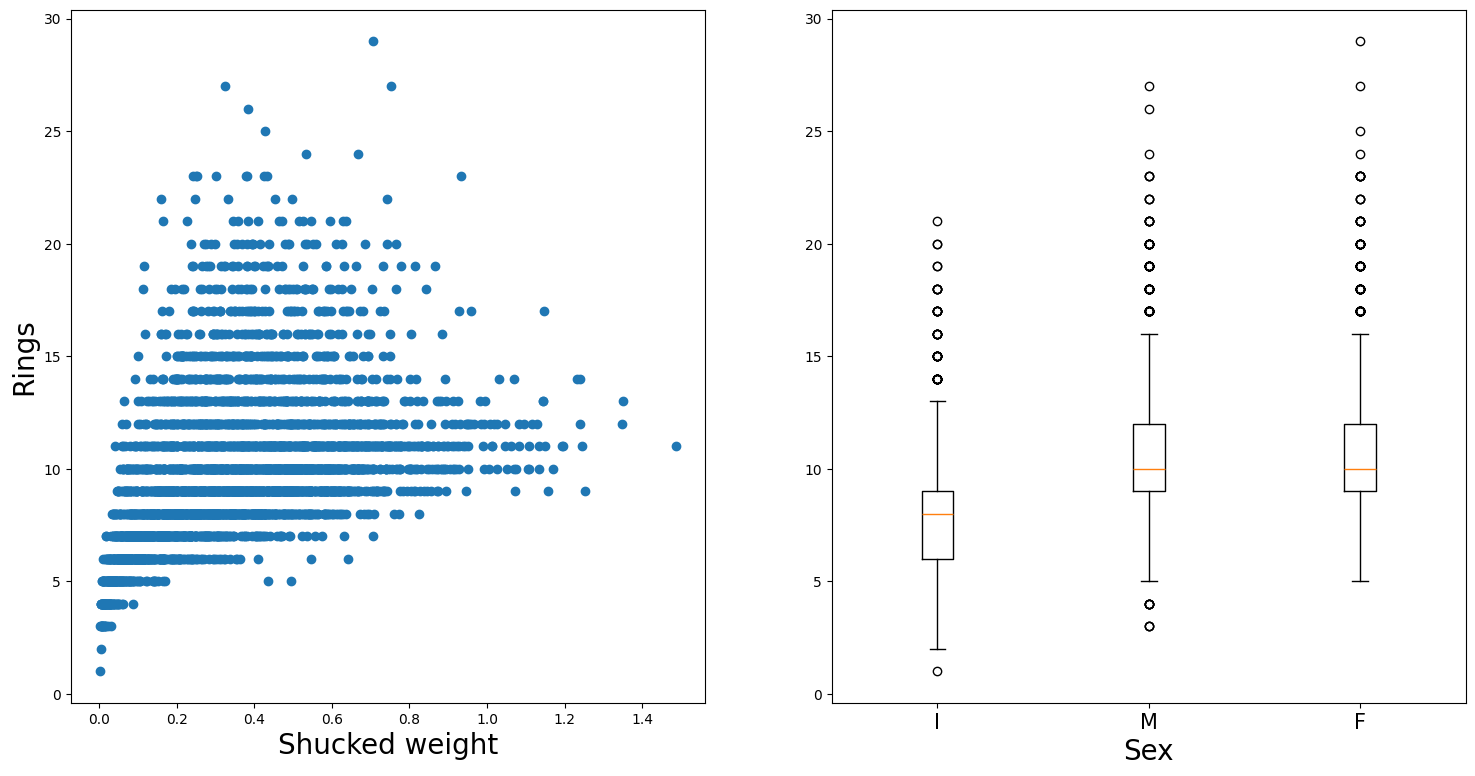

In [5]:
plt.figure(figsize=(18, 9))

#Plot 1
plt.subplot(121)
plt.scatter(data['shucked weight'],data['rings'])

plt.ylabel('Rings',size=20)
plt.xlabel('Shucked weight',size=20)

#Plot 2
plt.subplot(122)
plt.boxplot(data[data.sex=='I']['rings'],positions=[1])
plt.boxplot(data[data.sex=='M']['rings'],positions=[2])
plt.boxplot(data[data.sex=='F']['rings'],positions=[3])

plt.xticks(ticks=[1,2,3],labels=['I', 'M', 'F'],size= 15)
plt.xlabel('Sex',size=20)

plt.savefig('data_exploration.png',dpi=200,bbox_inches='tight')

## Feature Engineering

In [6]:
#Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)

X.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,0,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,0,1


## Train Model

In [7]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)

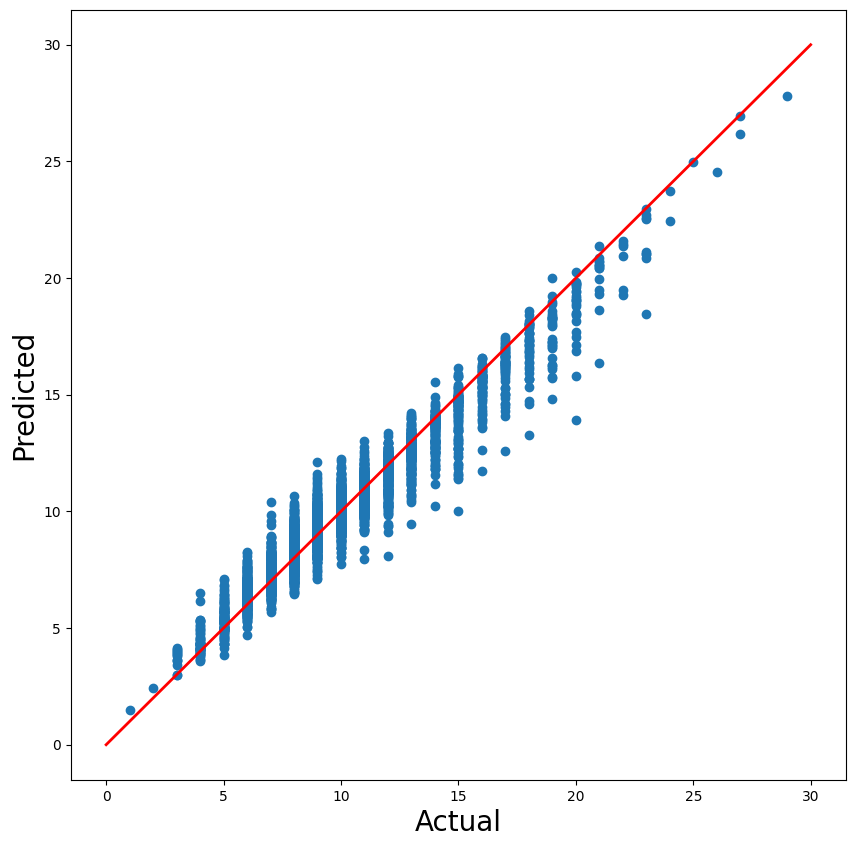

In [8]:
#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))

plt.scatter(y,y_pred)
plt.plot([0, 30], [0, 30], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

plt.savefig('regression_evaluation.png',dpi=200,bbox_inches='tight')

# SHAP

In [9]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

### Force Plots

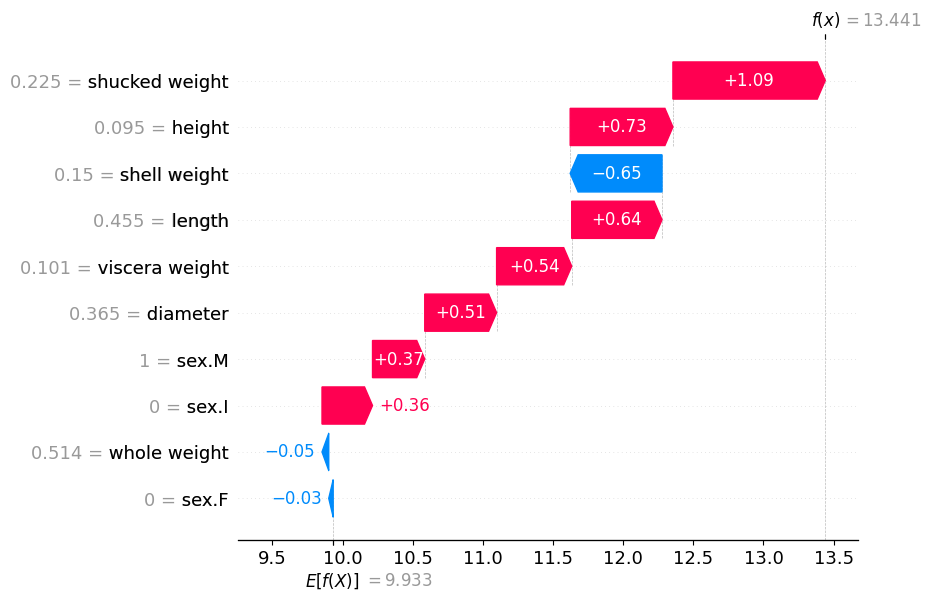

In [10]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [11]:
np.mean(y)

9.933684462532918

In [12]:
shap_values[0]

.values =
array([ 0.64371955,  0.51225305,  0.7323426 , -0.04798808,  1.0858843 ,
        0.5353621 , -0.65465117,  0.37221202, -0.03157707,  0.36000517],
      dtype=float32)

.base_values =
9.932957

.data =
array([0.455 , 0.365 , 0.095 , 0.514 , 0.2245, 0.101 , 0.15  , 1.    ,
       0.    , 0.    ])

In [13]:
# Waterfall plot for first observation
shap.initjs()
shap.plots.force(shap_values[0])

In [14]:
shap.initjs()
shap.plots.force(shap_values[0:100])

## Mean SHAP

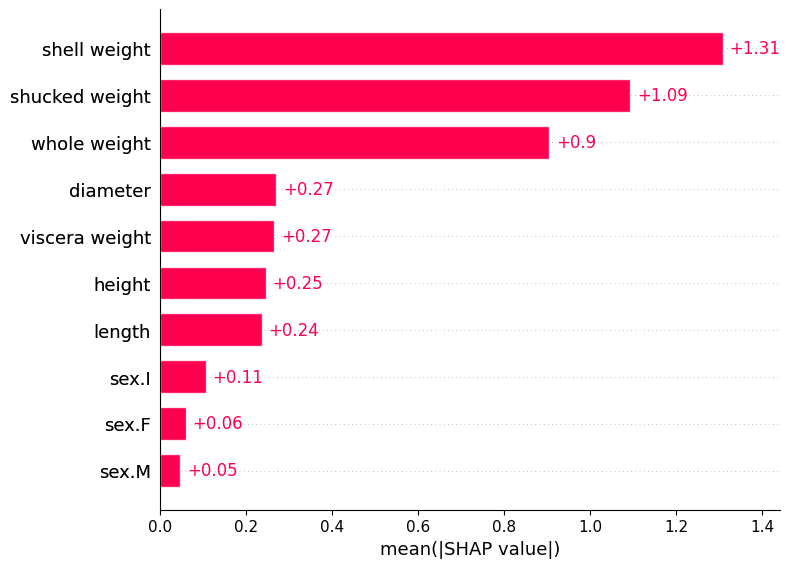

In [15]:
#Mean SHAP
shap.plots.bar(shap_values,show=False)
plt.savefig('mean_shap.png',dpi=200,bbox_inches='tight')

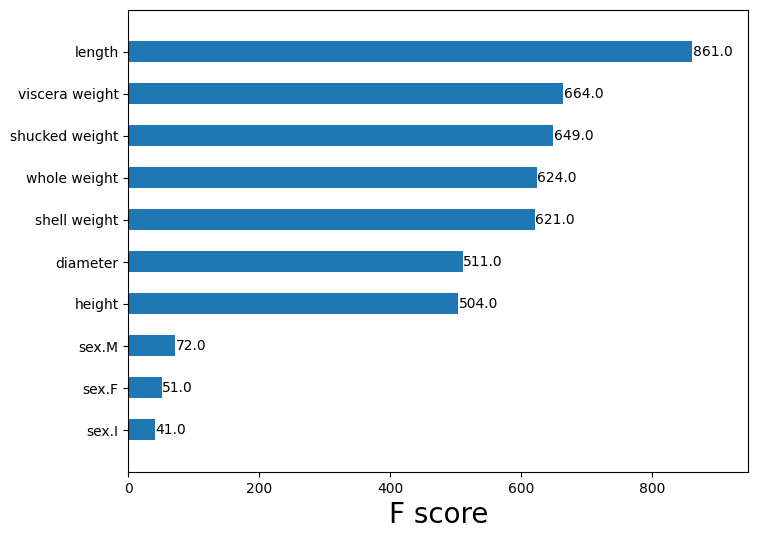

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
plot_importance(model,ax=ax,grid=False,height=0.5)

plt.title('')
plt.ylabel('')
plt.xlabel('F score',size=20)

plt.savefig('Feature_importance.png',dpi=200 ,bbox_inches='tight')

## Decision Plot

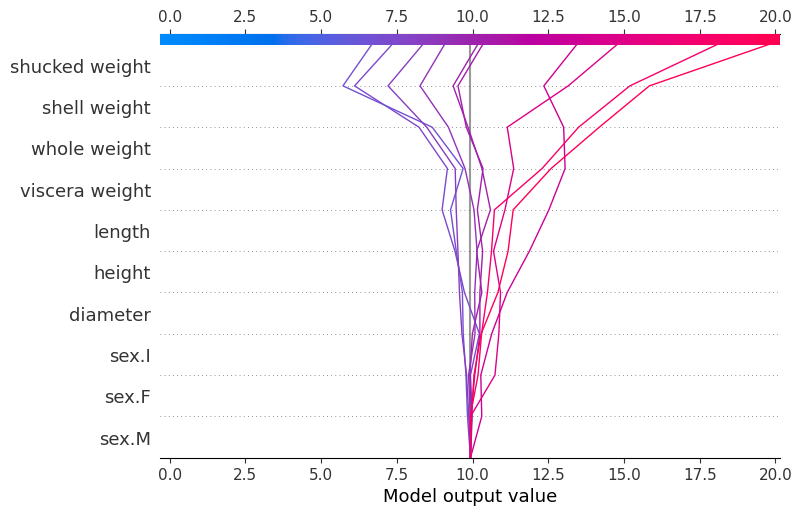

In [17]:
# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X.columns),show=False)

plt.savefig('decision_plot.png',dpi=200,bbox_inches='tight')

## Beeswarm

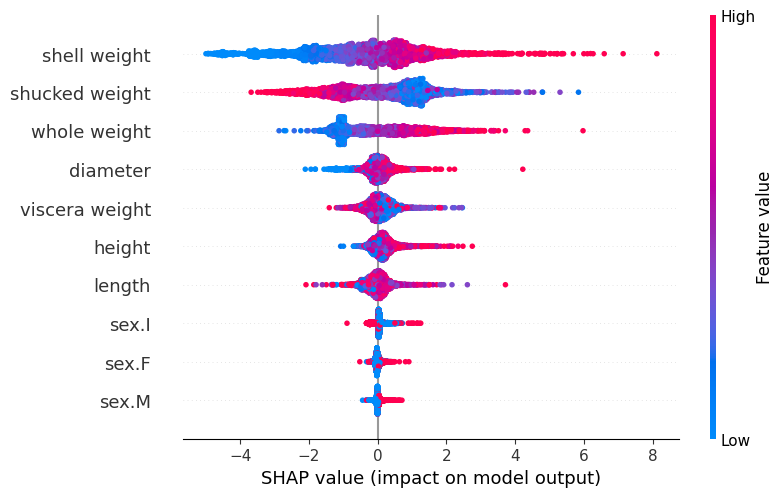

In [18]:
# Beeswarm plot
shap.plots.beeswarm(shap_values,show=False)

plt.savefig('beeswarm.png',dpi=200,bbox_inches='tight')

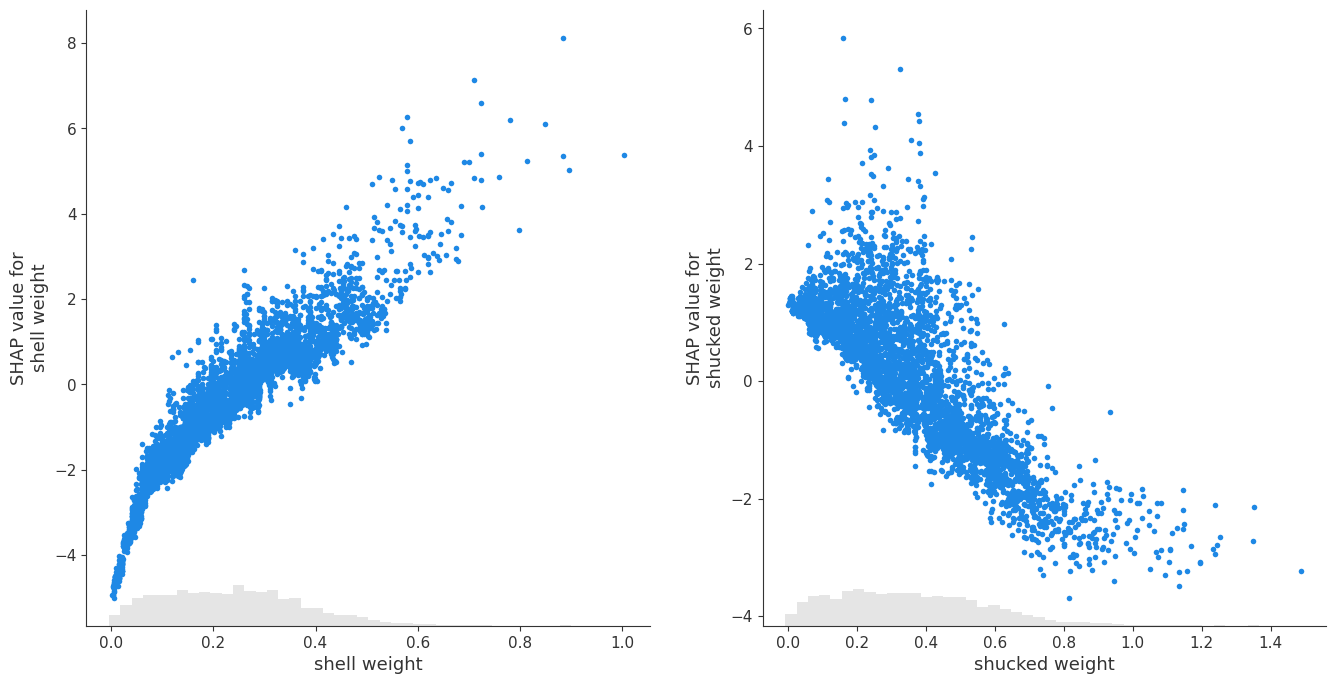

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

shap.plots.scatter(shap_values[:,"shell weight"],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,"shucked weight"],ax=ax[1],show=False)

plt.savefig('shap_scatter.png',dpi=200,bbox_inches='tight')

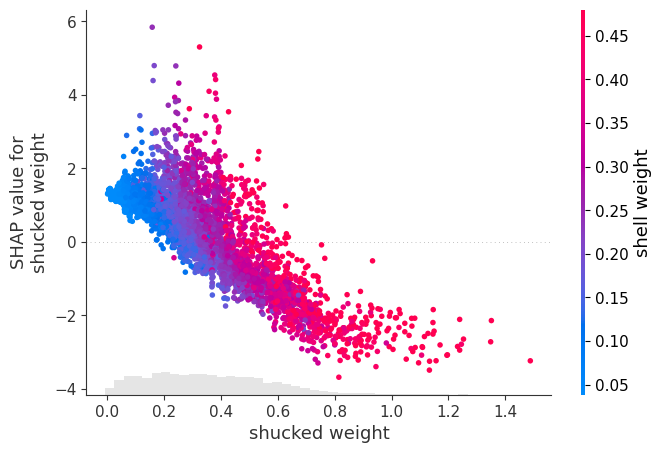

In [20]:
shap.plots.scatter(shap_values[:,"shucked weight"],color=shap_values[:,"shell weight"])

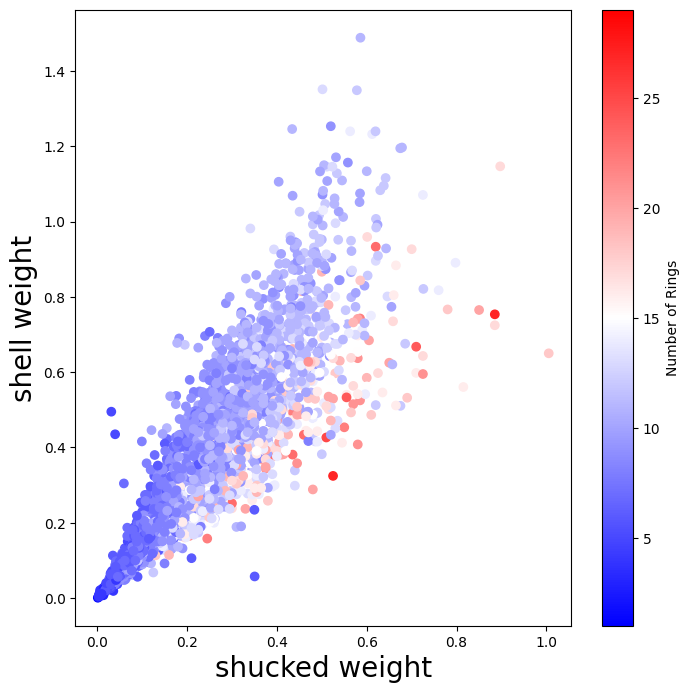

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(data["shell weight"],data["shucked weight"],c=data["rings"],cmap='bwr')
plt.colorbar(label="Number of Rings", orientation="vertical")

plt.xlabel('shucked weight',size=20)
plt.ylabel('shell weight',size=20)

plt.savefig('weight_interaction.png',dpi=200,bbox_inches='tight')

## Binary Target Variable

In [22]:
#Binary target varibale
y = [1 if y_>10 else 0 for y_ in y]

#Train model
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

y_pred = model.predict(X)

print(confusion_matrix(y, y_pred))
accuracy_score(y, y_pred)

[[2688   42]
 [ 112 1335]]


0.9631314340435719

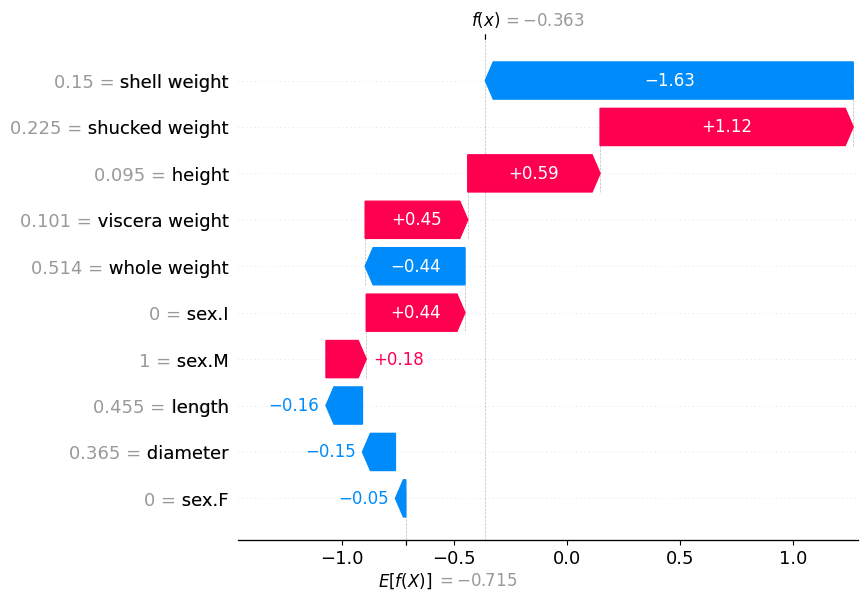

In [23]:
#Get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

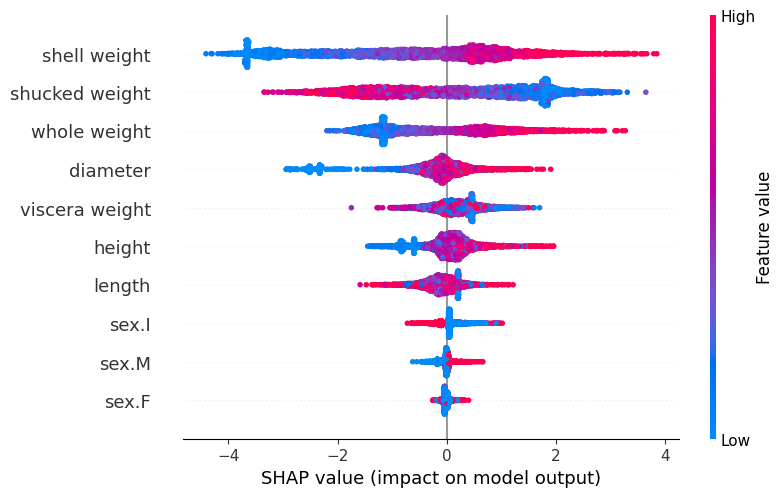

In [24]:
shap.plots.beeswarm(shap_values)